# A simple neural network from scratch, Python only

Here I implement a simple two-layer neural network and train it on the MNIST digit recognizer dataset. This was a helpful example for understanding the math & algorithms behind neural networks.

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv("MNIST_train.csv")

In [3]:
data = np.array(data)  # convert to numpy array
m, n = data.shape  # get dimensions - m is number of examples, n is number of features
np.random.shuffle(data)  # shuffle before splitting into dev and training sets
print(f"The shape is {data.shape}, there are {m} examples and {n} features")

# transpose so columns are examples, and rows are features (to fit math convention on NNs)
data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.0

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.0
_, m_train = X_train.shape

The shape is (42000, 785), there are 42000 examples and 785 features


In [4]:
Y_train

array([7, 7, 8, ..., 5, 6, 4])

This NN will have a simple two-layer architecture. Input layer $a^{[0]}$ will have 784 units corresponding to the 784 pixels in each 28x28 input image. A hidden layer $a^{[1]}$ will have 10 units with ReLU activation, and finally our output layer $a^{[2]}$ will have 10 units corresponding to the ten digit classes with softmax activation.

**Forward propagation**

$$Z^{[1]} = W^{[1]} X + b^{[1]}$$
$$A^{[1]} = g_{\text{ReLU}}(Z^{[1]}))$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$
$$A^{[2]} = g_{\text{softmax}}(Z^{[2]})$$

**Backward propagation**

$$dZ^{[2]} = A^{[2]} - Y$$
$$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T}$$
$$dB^{[2]} = \frac{1}{m} \Sigma {dZ^{[2]}}$$
$$dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (z^{[1]})$$
$$dW^{[1]} = \frac{1}{m} dZ^{[1]} A^{[0]T}$$
$$dB^{[1]} = \frac{1}{m} \Sigma {dZ^{[1]}}$$

**Parameter updates**

$$W^{[2]} := W^{[2]} - \alpha dW^{[2]}$$
$$b^{[2]} := b^{[2]} - \alpha db^{[2]}$$
$$W^{[1]} := W^{[1]} - \alpha dW^{[1]}$$
$$b^{[1]} := b^{[1]} - \alpha db^{[1]}$$

**Vars and shapes**

Forward prop

- $A^{[0]} = X$: 784 x m
- $Z^{[1]} \sim A^{[1]}$: 10 x m
- $W^{[1]}$: 10 x 784 (as $W^{[1]} A^{[0]} \sim Z^{[1]}$)
- $B^{[1]}$: 10 x 1
- $Z^{[2]} \sim A^{[2]}$: 10 x m
- $W^{[1]}$: 10 x 10 (as $W^{[2]} A^{[1]} \sim Z^{[2]}$)
- $B^{[2]}$: 10 x 1

Backprop

- $dZ^{[2]}$: 10 x m ($~A^{[2]}$)
- $dW^{[2]}$: 10 x 10
- $dB^{[2]}$: 10 x 1
- $dZ^{[1]}$: 10 x m ($~A^{[1]}$)
- $dW^{[1]}$: 10 x 10
- $dB^{[1]}$: 10 x 1

In [5]:
# CELL TO DEFINE ALL THE FUNCTIONS (with explanations)


def init_params():
    """
    Initializes the parameters for a two-layer neural network.
    Weights & bias init with random values from uniform distribution in range (-0.5, 0.5).

    Returns: W1, b1, W2, b2 (all np.ndarray):
        Initialized weights and biases for the two layers.
    """
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    # why init with random values? break symmetry, ensure neurons learn different things
    return W1, b1, W2, b2


def ReLU(Z):
    """
    ReLU (Rectified Linear Unit) activation function
    Returns the element-wise max of 0 and Z. Return Z if Z > 0, else return 0.
    Element-wise max = max selected from each pair of corresponding elements of arrays
    Why? ReLU allows the network to learn non-linear functions; also fast, simple

    Parameters: Z (np.ndarray): Output of the linear layer.
    Returns: A (np.ndarray): Output of the ReLU function (activation matrix)
    """
    return np.maximum(Z, 0)


def softmax(Z):
    """
    Softmax activation function - works well for multiclass classification problems
    Parameters: Z (np.ndarray): Output of the linear layer.
    Returns: A (np.ndarray): Output of the softmax function (activation matrix)
    """
    A = np.exp(Z) / sum(np.exp(Z))
    return A


def forward_prop(W1, b1, W2, b2, X):
    """
    Forward propagation for 2-layer NN - takes the dot product of the weights and inputs,
    adds the bias, and applies the activation function. Returns the activations of the
    hidden and output layers. Dot product = sum of products of corresponding entries.
    Parameters: W1, b1, W2, b2 (np.ndarray): Weights and biases for the 2 layers.
    Returns: Z1, A1, Z2, A2 (np.ndarray): Outputs from the forward propagation.
    """
    Z1 = W1.dot(X) + b1  # first layer; apply weights and bias
    A1 = ReLU(Z1)  # apply ReLU activation function
    Z2 = W2.dot(A1) + b2  # second layer; apply weights and bias
    A2 = softmax(Z2)  # apply softmax activation
    return Z1, A1, Z2, A2


def ReLU_deriv(Z):
    """
    Derivative of ReLU activation function - returns 1 if Z > 0, else return 0.
    Parameters: Z (np.ndarray): Output of the linear layer.
    Returns: dZ (np.ndarray): Derivative of the cost with respect to Z.
    """
    return Z > 0


def one_hot(Y):
    """
    Converts a vector of labels (Y) into a one-hot matrix.
    Used to allow math operations for modeling categorical data

    Parameters:
    Y (np.ndarray): A 1D numpy array of class labels.

    Returns:
    one_hot_Y (np.ndarray): A 2D numpy array - each column corresponds to a label,
    and each row corresponds to a class. For each column, all elements are 0
    except for the row that corresponds to its class, which is 1.
    """
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))  # create matrix of zeros
    one_hot_Y[np.arange(Y.size), Y] = 1  # set correct column to 1 for each row
    one_hot_Y = one_hot_Y.T
    return one_hot_Y


def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    """
    Backward propagation for 2-layer NN - calculates the derivatives of the cost function
    with respect to the weights and biases. This is done by applying the chain rule to
    find the derivative of the cost with respect to the parameters of the model.

    Parameters:
    Z1, A1, Z2, A2 (np.ndarray): Outputs from the forward propagation.
    W1, W2 (np.ndarray): Weights from the 2 layers.
    X (np.ndarray): Input data.
    Y (np.ndarray): True labels (from the training data)

    Returns:
    dW1, db1, dW2, db2 (np.ndarray):
    Gradients of the cost with respect to the weights and biases.
    """
    m = X.shape[1]  # number of examples
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2


def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    """
    Updates the parameters of the neural network using the gradients computed in the backward propagation step.

    Parameters:
    W1, b1, W2, b2 (np.ndarray): Current weights and biases of the neural network.
    dW1, db1, dW2, db2 (np.ndarray): Gradients of the cost with respect to the weights and biases.
    alpha (float): Learning rate for the gradient descent optimization algorithm.

    Returns:
    W1, b1, W2, b2 (np.ndarray): Updated weights and biases of the neural network.
    """
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    return W1, b1, W2, b2

In [6]:
def get_predictions(A2):
    """
    Returns the predictions for each example in A2 (output of the softmax function).
    Parameters: A2 (np.ndarray): Output of the softmax function.
    Returns: predictions (np.ndarray): Predictions for each example in A2.
    """
    return np.argmax(A2, 0)


def get_accuracy(predictions, Y):
    """
    Returns the accuracy of the predictions, given the true labels.
    Parameters:
        predictions (np.ndarray): Predictions for each example in A2.
        Y (np.ndarray): True labels (from the training data)
    Returns: accuracy (float): Accuracy of the predictions.
    """
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size


def gradient_descent(X, Y, alpha, iterations):
    """
    Implements gradient descent for a 2-layer neural network. Puts it all together!
    Parameters:
        X (np.ndarray): Input data.
        Y (np.ndarray): True labels (from the training data)
        alpha (float): Learning rate for the gradient descent optimization algorithm.
        iterations (int): Number of iterations of the optimization loop.
    Returns:
        W1, b1, W2, b2 (np.ndarray): Updated weights and biases of the neural network.
    """
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2

In [7]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.10, 500)

Iteration:  0
[7 7 7 ... 7 7 7] [7 7 8 ... 5 6 4]
0.09851219512195122
Iteration:  10
[5 3 3 ... 4 8 5] [7 7 8 ... 5 6 4]
0.16265853658536586
Iteration:  20
[6 5 6 ... 4 6 9] [7 7 8 ... 5 6 4]
0.25182926829268293
Iteration:  30
[6 5 6 ... 4 6 9] [7 7 8 ... 5 6 4]
0.331609756097561
Iteration:  40
[6 7 7 ... 9 6 9] [7 7 8 ... 5 6 4]
0.40175609756097563
Iteration:  50
[7 7 7 ... 9 6 9] [7 7 8 ... 5 6 4]
0.45158536585365855
Iteration:  60
[7 7 7 ... 4 6 9] [7 7 8 ... 5 6 4]
0.496
Iteration:  70
[7 7 8 ... 4 6 9] [7 7 8 ... 5 6 4]
0.5373902439024391
Iteration:  80
[7 7 8 ... 4 6 9] [7 7 8 ... 5 6 4]
0.5804634146341463
Iteration:  90
[7 7 8 ... 4 6 4] [7 7 8 ... 5 6 4]
0.6172926829268293
Iteration:  100
[7 7 8 ... 4 6 4] [7 7 8 ... 5 6 4]
0.6458780487804878
Iteration:  110
[7 7 8 ... 5 6 4] [7 7 8 ... 5 6 4]
0.6679268292682927
Iteration:  120
[7 7 8 ... 5 6 4] [7 7 8 ... 5 6 4]
0.686
Iteration:  130
[9 7 8 ... 5 6 4] [7 7 8 ... 5 6 4]
0.7009756097560975
Iteration:  140
[9 7 8 ... 5 6 4] [7 7 

~85% accuracy on training set.

In [8]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions


def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)

    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation="nearest")
    plt.show()

Let's look at a couple of examples:

Prediction:  [7]
Label:  7


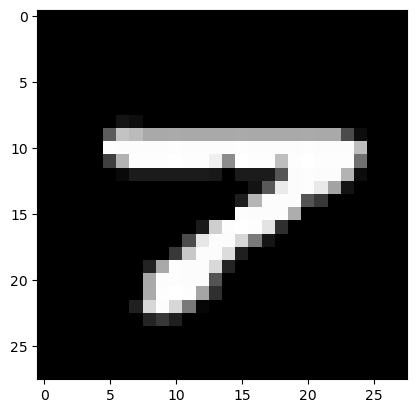

Prediction:  [7]
Label:  7


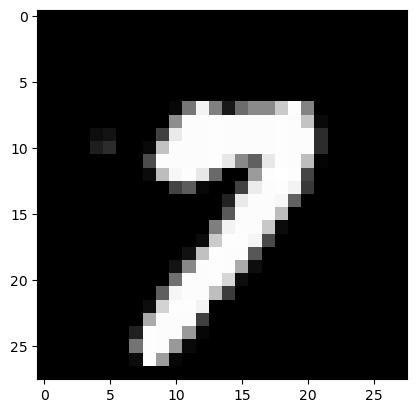

Prediction:  [8]
Label:  8


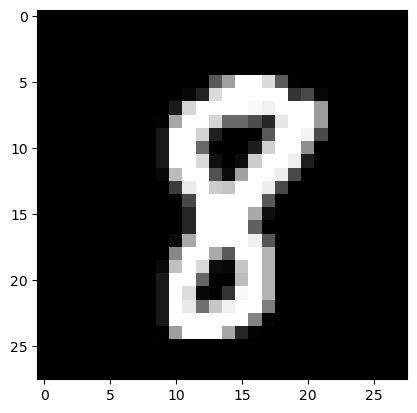

Prediction:  [2]
Label:  2


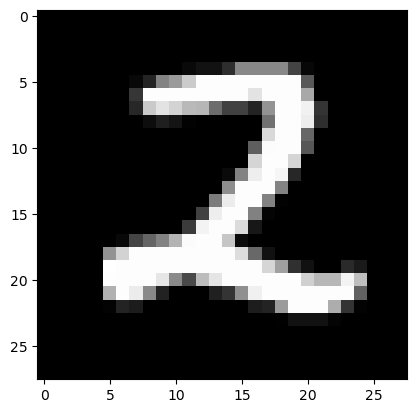

In [9]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

Finally, let's find the accuracy on the dev set:

In [10]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
get_accuracy(dev_predictions, Y_dev)

[4 9 2 6 5 0 4 3 9 9 7 4 7 0 6 9 3 7 3 3 9 3 2 1 1 8 3 3 8 4 4 0 0 2 3 0 4
 4 1 4 1 9 0 5 2 7 8 0 2 9 6 6 7 4 1 4 3 4 3 7 1 1 1 4 1 0 9 6 5 1 1 2 9 7
 4 1 3 3 3 2 8 2 3 5 8 6 0 1 3 2 7 4 3 3 3 8 2 8 4 8 5 0 0 6 8 5 6 0 6 3 3
 6 1 7 3 0 0 0 9 6 9 2 4 4 4 0 2 0 2 9 8 7 7 3 0 7 1 0 2 4 5 3 8 8 6 5 6 0
 3 0 3 7 5 2 0 1 4 6 4 7 2 7 6 6 0 8 9 6 7 9 0 9 1 5 5 8 6 7 4 5 4 7 1 7 6
 3 4 2 5 2 8 5 1 8 0 7 4 7 9 5 6 3 3 5 5 6 3 1 9 0 4 1 5 4 7 6 2 8 8 3 3 9
 0 9 9 3 8 4 0 2 0 2 9 7 1 2 6 3 8 8 4 4 3 5 4 2 9 8 3 0 8 2 0 9 4 8 6 0 4
 9 0 4 8 3 6 5 4 0 4 3 4 3 4 6 3 9 0 2 4 7 3 2 7 5 3 7 7 9 1 5 8 3 0 7 7 9
 5 3 1 6 9 9 3 8 9 5 1 2 3 0 1 1 4 5 2 8 1 8 7 8 3 9 3 0 8 0 1 4 8 5 3 4 2
 2 2 8 6 6 3 2 9 2 6 4 9 9 2 9 7 4 0 9 0 5 3 7 6 0 2 8 1 8 7 2 6 0 2 7 8 1
 3 6 6 9 0 0 6 5 8 4 2 0 2 8 1 9 8 0 3 0 6 8 4 4 1 6 7 9 2 8 1 1 1 6 7 5 3
 3 0 1 1 6 3 4 3 3 0 1 6 4 5 7 5 6 3 6 8 1 8 1 4 9 1 4 3 4 8 9 5 0 0 0 5 4
 2 0 2 6 8 4 9 6 7 6 5 2 3 6 0 9 3 4 5 8 3 9 6 0 7 6 8 9 3 2 3 6 3 8 8 2 1
 8 6 2 3 2 0 3 4 1 4 5 5 

0.854

Still **84% accuracy**, so our model generalized from the training data pretty well.

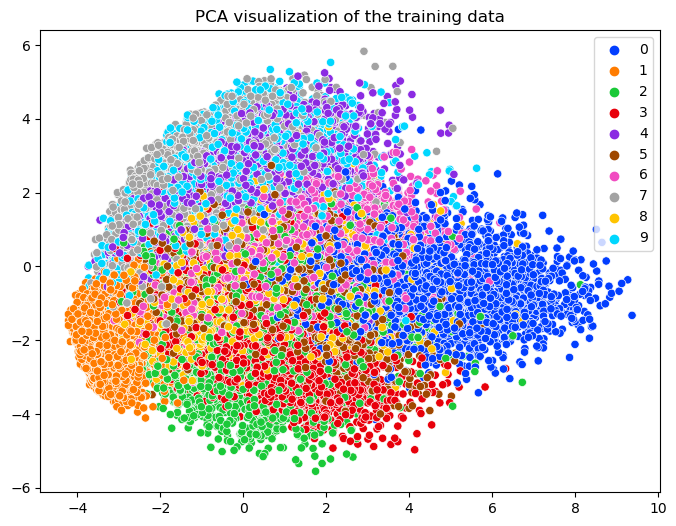

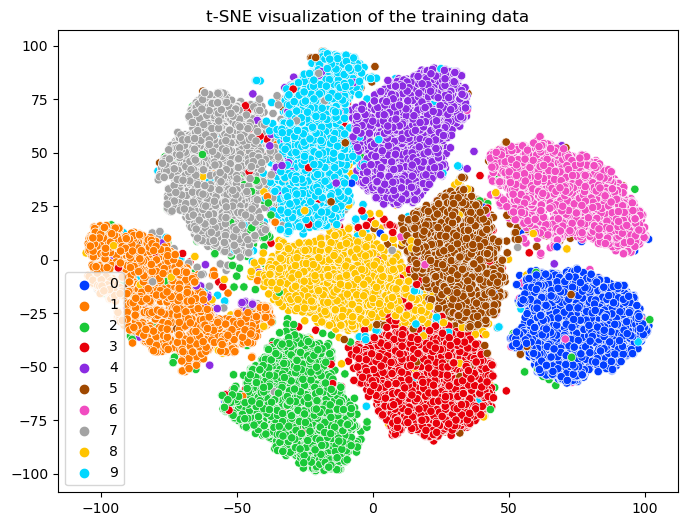

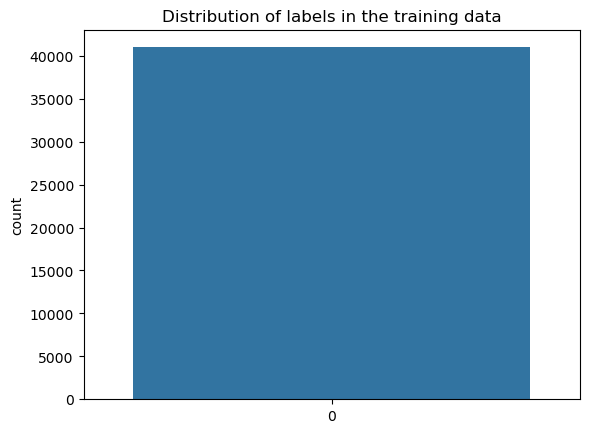

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# %% cell 17

# Visualizing the data using PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train.T)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=Y_train, palette="bright")
plt.title("PCA visualization of the training data")
plt.show()

# %% cell 18

# Visualizing the data using t-SNE
tsne = TSNE(n_components=2, random_state=0)
X_train_tsne = tsne.fit_transform(X_train.T)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_train_tsne[:, 0], y=X_train_tsne[:, 1], hue=Y_train, palette="bright"
)
plt.title("t-SNE visualization of the training data")
plt.show()